# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 58 kB 3.5 MB/s 
     |████████████████████████████████| 376 kB 44.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=874b29080fcbeb5b90cf86d311b929bfccbdea4a246b91d13e8708225153ef4a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=32186e9747e5c87502aa22a4dd7c602bdd620bf6f0cf5d7cd0a034e6d46f22a9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

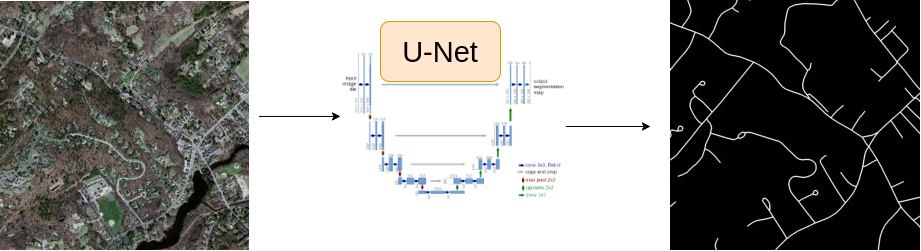

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 15

row = df.iloc[idx]

image_path= DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

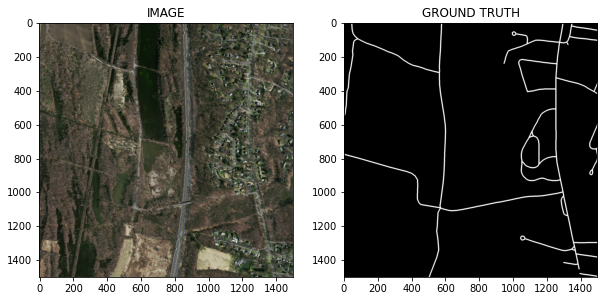

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path= DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#(h,w,c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)#(h,w)
    mask = np.expand_dims(mask, axis = -1)#(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


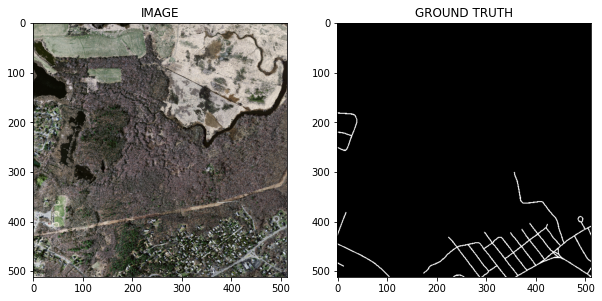

In [ ]:
idx = 21

image, mask = validset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import  DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [ ]:
for images, masks in trainloader:
  print(f'One batche image shape : {images.shape}')
  print(f'One batche mask shape : {masks.shape}')
  break;

One batche image shape : torch.Size([8, 3, 512, 512])
One batche mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode ='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train() #Turn ON dropout, batchnorm, etc...

  total_loss=0.0

  for images, masks in tqdm(dataloader):

    images=images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [ ]:
def eval_fn(dataloader, model):

  model.eval() #Turn ON dropout, batchnorm, etc...

  total_loss=0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images=images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVE-MODEL")
    best_loss= valid_loss

  print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')




100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVE-MODEL
Epoch : 1 Train Loss : 1.162076508998871 Valid Loss : 1.2262823581695557


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVE-MODEL
Epoch : 2 Train Loss : 0.7940013319253921 Valid Loss : 0.9014552712440491


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVE-MODEL
Epoch : 3 Train Loss : 0.7129327178001403 Valid Loss : 0.7743969321250915


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVE-MODEL
Epoch : 4 Train Loss : 0.6715277701616287 Valid Loss : 0.7536051630973816


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVE-MODEL
Epoch : 5 Train Loss : 0.6614791065454483 Valid Loss : 0.7023696303367615


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 6 Train Loss : 0.644700875878334 Valid Loss : 0.7312749266624451


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVE-MODEL
Epoch : 7 Train Loss : 0.6351195573806763 Valid Loss : 0.6700865030288696


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 8 Train Loss : 0.6304485380649567 Valid Loss : 0.6886761426925659


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 9 Train Loss : 0.622042502462864 Valid Loss : 0.6957333326339722


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVE-MODEL
Epoch : 10 Train Loss : 0.617165493965149 Valid Loss : 0.6384264945983886


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 11 Train Loss : 0.6142869248986245 Valid Loss : 0.6397589564323425


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVE-MODEL
Epoch : 12 Train Loss : 0.6105045258998871 Valid Loss : 0.6380521774291992


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 13 Train Loss : 0.6113564819097519 Valid Loss : 0.6781168222427368


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVE-MODEL
Epoch : 14 Train Loss : 0.5925282984972 Valid Loss : 0.6343742251396179


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 15 Train Loss : 0.5939037948846817 Valid Loss : 0.6623768091201783


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 16 Train Loss : 0.5874722510576248 Valid Loss : 0.6616367697715759


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 17 Train Loss : 0.5831483334302903 Valid Loss : 0.637499725818634


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 18 Train Loss : 0.5815782442688942 Valid Loss : 0.6359797239303588


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 19 Train Loss : 0.5787523418664933 Valid Loss : 0.653836452960968


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVE-MODEL
Epoch : 20 Train Loss : 0.5740260750055313 Valid Loss : 0.6294755458831787


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 21 Train Loss : 0.5681844979524613 Valid Loss : 0.658974027633667


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVE-MODEL
Epoch : 22 Train Loss : 0.5662917286157608 Valid Loss : 0.6204309940338135


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch : 23 Train Loss : 0.566575275361538 Valid Loss : 0.6271626591682434


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 24 Train Loss : 0.593350636959076 Valid Loss : 0.6914247035980224


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

Epoch : 25 Train Loss : 0.5816555559635163 Valid Loss : 0.6368866205215454


# Task 9 : Inference

In [ ]:
idx = 28

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w)-> (b,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

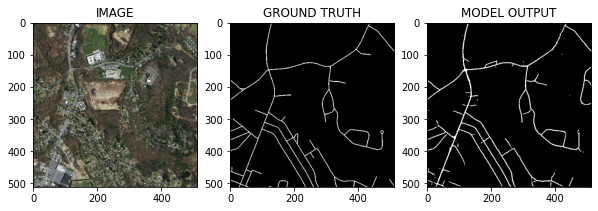

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))